#### Laurent Jutras-Dubé

## Model of light-induced hESC colony patterning

####   

This Jupyter notebook simulates the mathematical model of the paper titled "Optogenetic-Programmable Human Embryo Models Elucidate the Interplay Between Tissue Architecture and BMP4 Signaling at the Onset of Gastrulation" by Riccardo De Santis, Laurent Jutras-Dubé, Sophia Bourdrel, Eleni Rice, Francesco Piccolo, and Ali H. Brivanlou.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.animation import (FuncAnimation, writers)

import OptoBMP4_functions as fct

<br>

We first write a parameter dictionary that lists all parameters required for modeling the dynamics of BMP4, WNT and NODAL signaling.

In [2]:
param = {
    
    # BMP
    "p_BMP4"     : 0.1,
    "D_BMP4"     : 0.1,
    "l_BMP4"     : 0.002,
    "x_light"    : 250.,
    "fixed_BMP4" : 0.,
    
    # Noggin
    "p_NOG" : 0.07,
    "D_NOG" : 10.,
    "l_NOG" : 0.001,
    "a"        : 1.,
    
    # Wnt
    "p1_WNT3" : 0.6,
    "p2_WNT3" : 0.06,
    "D_WNT3"  : 4.,
    "l_WNT3"  : 0.005,
    "T_WNT3"  : 0.6,
    
    # Nodal
    "p_NODAL" : 0.13,
    "D_NODAL" : 1.,
    "l_NODAL" : 0.002,

    # pSMAD1
    "n_pSMAD1" : 1.4,
    "K_pSMAD1" : 35.,
    
    # YAP
    "n_nYAP" : 2.5,
    "K_nYAP" : 0.975,
    "fixed_nYAP" : 0.,

    # bCatenin
    "n_bCAT" : 3.6,
    "K_bCAT" : 20.,

    # pSMAD2
    "n_pSMAD2" : 2.,
    "K_pSMAD2" : 20.,

    # SOX2
    "n_SOX2"  : 8.,
    "K_SOX2"  : 0.5,
    "n2_SOX2" : 8.,
    "K2_SOX2" : 0.5,

    # ISL1
    "n_ISL1" : 8.,
    "K_ISL1" : 0.5,

    # BRA
    "n_BRA"  : 8.,
    "K_BRA"  : 0.5,
    "n2_BRA" : 8.,
    "K2_BRA" : 0.5,
    "n3_BRA" : 8.,
    "K3_BRA" : 0.5,
    
    # Array size, time points, and radius
    "times"     : np.linspace(0., 5e3, 500),
    "x_total"   : 250.,
    "x_arr_len" : 300,

    # Modeling micropatterns?
    "micro" : False
    
}

<br>

In micropatterns, the sensisitivity to BMP4 depends on the distance from the micropattern's edge. Similarly to our previous mathematical model (Etoc et al., 2016), we capture this dependency, as well as the tension parameter, through the following functions.

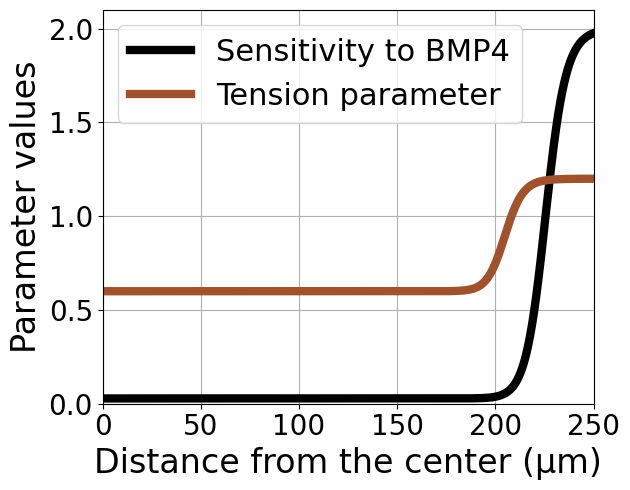

In [3]:
x_total = 250.
x = np.linspace(0., x_total, 1000)
r = x-x_total+205.
K_mp = param["K_pSMAD1"]/(1.+(r/160.)**35.)+0.5
T_mp = 0.6*(r/160.)**35./(1.+(r/160.)**35.)+0.6


fig, ax = plt.subplots(figsize=[6.4, 5.])

# Edge-dependent parameters
ax.plot(x, 1./K_mp, c='k', lw=6, label='Sensitivity to BMP4')
ax.plot(x, T_mp, c='sienna', lw=6, label='Tension parameter')
ax.set_xlabel('Distance from the center (µm)', fontsize=24)
ax.set_ylabel('Parameter values', fontsize=24)
ax.set_xlim(0., x_total)
ax.set_ylim(0., 2.1)
ax.tick_params(labelsize=20)
ax.grid()
ax.legend(fontsize=22)

fig.tight_layout()
fig.savefig('Figures/FIG4B_micropattern_edge_parameter_values.pdf', dpi=300)

<br>

In regular culture, the tension parameter is homogeneous due to the absence of a physical edge, but can be modulated by epithelial domain reorganization. Moreover, the sensisitivity to BMP4 depends on the distance from the edge of the illuminated region. We capture this dependency through the following function.

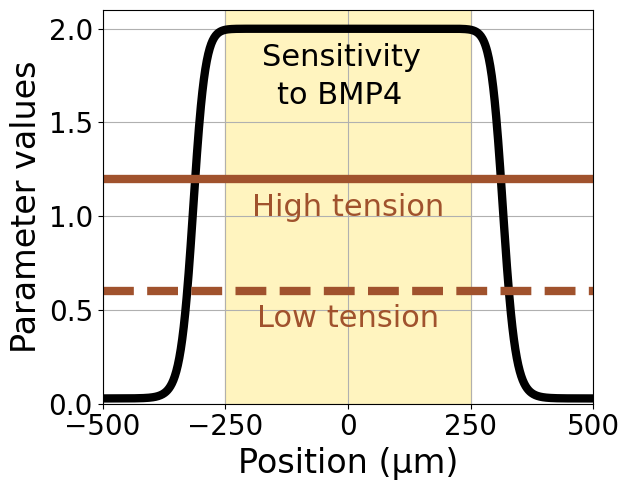

In [4]:
x_total, x_light = 500., 250.
x = np.linspace(-x_total, x_total, 1000)
r = x-x_total+205.
r[r<0.] = 0.
K_mp = param["K_pSMAD1"]*(np.abs(x)**25./((x_light*1.5)**25.+np.abs(x)**25.))+0.5


fig, ax = plt.subplots(figsize=[6.4, 5.])

# Edge-dependent BMP4 parameter (pSMAD1 sensitivity to BMP4 induction)
ax.plot(x, 1./K_mp, c='k', lw=6, label='Sensitivity to BMP4')
ax.plot([-x_total, x_total], [1.2, 1.2], c='sienna', lw=6, label='Tension parameter,\nhigh tension')
ax.plot([-x_total, x_total], [0.6, 0.6], c='sienna', ls='--', lw=6, label='Low tension')
ax.set_xlabel('Position (µm)', fontsize=24)
ax.set_ylabel('Parameter values', fontsize=24)
ax.set_xlim(-x_total, x_total)
ax.set_ylim(0., 2.1)
ax.set_xticks([-500., -250., 0., 250., 500.])
ax.tick_params(labelsize=20)
ax.grid()
# ax.legend(fontsize=18)

ax.fill_between([-x_light,x_light], [-1.,-1.], [65.,65.], color='gold', alpha=0.25)
ax.text(-175., 1.8, 'Sensitivity', c='k', fontsize=22)
ax.text(-145., 1.6, 'to BMP4', c='k', fontsize=22)
ax.text(-195., 1., 'High tension', c='sienna', fontsize=22)
ax.text(-185., 0.41, 'Low tension', c='sienna', fontsize=22)

fig.tight_layout()
fig.savefig('Figures/FIG4C_regular_culture_parameter_values.pdf', dpi=300)

<br>

To model the dynamics of morphogens, transcription factors, and fate markers, we use the `integrate` function, which integrates the partial differential equations (PDEs) found in the `PDEs` function. We then use the plotting functions to visualize the results.

<!-- In regular cultures, there is obviously no micropattern edge to speak of, and thus the boundary conditions for diffusing particles are different than with micropatterned substrates. We use reflective boundary conditions at the borders (walls) of the regular cultures, while we set the concentration of diffusing particles to 0 at the edge of the micropatterns, since there, diffusing particles get diluted (lost) in the media. Also note that when modelling BMP4 and Nodal dynamics within micropatterns, the spatial coordinate represents the distance from the center $r$, and thus the diffusion term has an extra term compared to the diffusion term for regular cell cultures.  -->

#### 1. Modeling soluble BMP4 presentation in micropatterns

In [6]:
# Position along the micropattern
param["x_arr_len"] = 300
param["x_total"] = 250.
x_MPF = np.linspace(0., param["x_total"], param["x_arr_len"])

# Parameters
param["times"] = np.linspace(0.1, 5e3, 500)
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 0.6
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

# BMP4, NOGGIN, WNT3 and NODAL concentrations
results_MPF = fct.integrate(param)
BMP4_MPF = results_MPF[:,:param["x_arr_len"]]
NOG_MPF = results_MPF[:,param["x_arr_len"]:2*param["x_arr_len"]]
WNT3_MPF = results_MPF[:,2*param["x_arr_len"]:3*param["x_arr_len"]]
NODAL_MPF = results_MPF[:,3*param["x_arr_len"]:]

# Sensitivity to BMP4 (K parameter)
K_pSMAD1 = param["K_pSMAD1"]    
r = x_MPF-param["x_total"]+205.
r[r<0.] = 0.
K_pSMAD1_MPF = K_pSMAD1/(1.+(r/160.)**35.)+(K_pSMAD1+10.)/110.

# Free BMP4
free_BMP4_MPF = BMP4_MPF/(1.+param["a"]*NOG_MPF)

# pSMAD1
pSMAD1_MPF = np.zeros(BMP4_MPF.shape)
n_pSMAD1 = param["n_pSMAD1"]
pSMAD1_MPF = free_BMP4_MPF**n_pSMAD1/(free_BMP4_MPF**n_pSMAD1+K_pSMAD1_MPF**n_pSMAD1)

# nYAP
nYAP_MPF = np.zeros(BMP4_MPF.shape)
n_nYAP, K_nYAP = param["n_nYAP"], param["K_nYAP"]
nYAP_MPF = pSMAD1_MPF**n_nYAP/(pSMAD1_MPF**n_nYAP+K_nYAP**n_nYAP)

# nß-CATENIN
bCAT_MPF = np.zeros(BMP4_MPF.shape)
n_bCAT, K_bCAT = param["n_bCAT"], param["K_bCAT"]
bCAT_MPF = WNT3_MPF**n_bCAT/(WNT3_MPF**n_bCAT+K_bCAT**n_bCAT)

# pSMAD2
pSMAD2_MPF = np.zeros(BMP4_MPF.shape)
n_pSMAD2, K_pSMAD2 = param["n_pSMAD2"], param["K_pSMAD2"]
pSMAD2_MPF = NODAL_MPF**n_pSMAD2/(NODAL_MPF**n_pSMAD2+K_pSMAD2**n_pSMAD2)

# ISL1
ISL1_MPF = np.zeros(BMP4_MPF.shape)
n_ISL1, K_ISL1 = param["n_ISL1"], param["K_ISL1"]
ISL1_MPF = pSMAD1_MPF**n_ISL1/(pSMAD1_MPF**n_ISL1+K_ISL1**n_ISL1)

# BRA
BRA_MPF = np.zeros(BMP4_MPF.shape)
n_BRA, K_BRA, n2_BRA, K2_BRA, n3_BRA, K3_BRA = param["n_BRA"], param["K_BRA"], param["n2_BRA"], param["K2_BRA"], param["n3_BRA"], param["K3_BRA"]
BRA_MPF = pSMAD2_MPF**n_BRA/(pSMAD2_MPF**n_BRA+K_BRA**n_BRA)
BRA_MPF *= K2_BRA**n2_BRA/(ISL1_MPF**n2_BRA+K2_BRA**n2_BRA)
BRA_MPF *= bCAT_MPF**n3_BRA/(bCAT_MPF**n3_BRA+K3_BRA**n3_BRA)

# SOX2
SOX2_MPF = np.ones(BMP4_MPF.shape)
n_SOX2, K_SOX2, n2_SOX2, K2_SOX2 = param["n_SOX2"], param["K_SOX2"], param["n2_SOX2"], param["K2_SOX2"]
SOX2_MPF = K_SOX2**n_SOX2/(pSMAD1_MPF**n_SOX2+K_SOX2**n_SOX2)
SOX2_MPF *= K2_SOX2**n2_SOX2/(BRA_MPF**n2_SOX2+K2_SOX2**n2_SOX2)

# Grouping results
morphogens_MPF = np.array([BMP4_MPF, free_BMP4_MPF, NOG_MPF, WNT3_MPF, NODAL_MPF])
TFs_MPF = np.array([pSMAD1_MPF, nYAP_MPF, bCAT_MPF, pSMAD2_MPF])
fates_MPF = np.array([SOX2_MPF, ISL1_MPF, BRA_MPF])

<br>

Figures

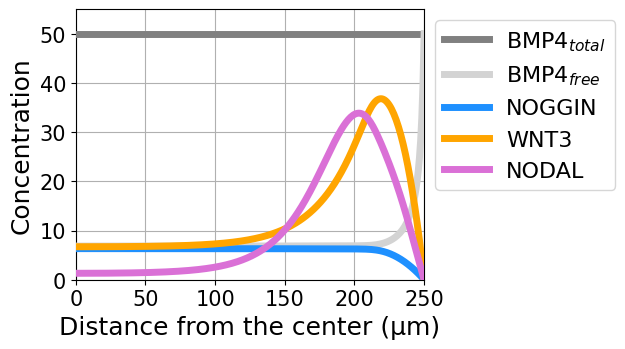

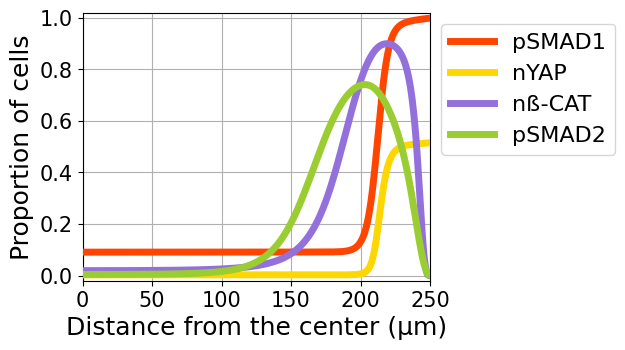

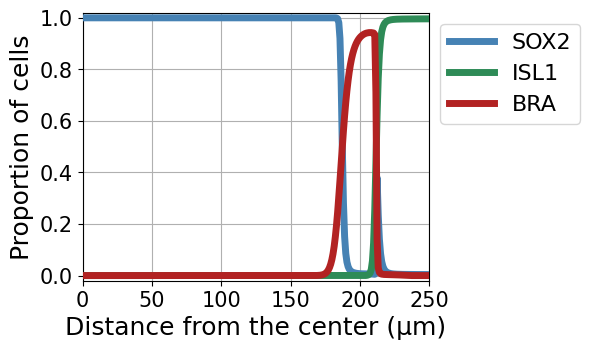

In [7]:
fct.plot_morphogens(x_MPF, morphogens_MPF[:,-1], 'Micropattern_solubleBMP4', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF, TFs_MPF[:,-1], 'Micropattern_solubleBMP4', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF, fates_MPF[:,-1], 'Micropattern_solubleBMP4', micro=True, fixed_BMP4=True)

<br>



#### 2. Modeling light-activated BMP4 in regular cultures in the low-tension regime

In [9]:
# Position along the micropattern
param["x_arr_len"] = 1000
param["x_total"] = 3700.
param["x_light"] = 250.
x_RCLL = np.linspace(-param["x_total"], param["x_total"], param["x_arr_len"])

# Parameters
param["times"] = np.linspace(0.1, 5e3, 500)
param["micro"] = False
param["fixed_BMP4"] = 0.
param["T_WNT3"] = 0.6
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

# BMP4, NOGGIN, WNT3 and NODAL concentrations
results_RCLL = fct.integrate(param)
BMP4_RCLL = results_RCLL[:,:param["x_arr_len"]]
NOG_RCLL = results_RCLL[:,param["x_arr_len"]:2*param["x_arr_len"]]
WNT3_RCLL = results_RCLL[:,2*param["x_arr_len"]:3*param["x_arr_len"]]
NODAL_RCLL = results_RCLL[:,3*param["x_arr_len"]:]

# Sensitivity to BMP4 (K parameter)
K_pSMAD1_RCLL = param["K_pSMAD1"]*np.abs(x_RCLL)**25./((param["x_light"]*1.5)**25.+np.abs(x_RCLL)**25.) +0.1

# Free BMP4
free_BMP4_RCLL = BMP4_RCLL/(1.+param["a"]*NOG_RCLL)

# pSMAD1
pSMAD1_RCLL = np.zeros(BMP4_RCLL.shape)
n_pSMAD1 = param["n_pSMAD1"]
pSMAD1_RCLL = free_BMP4_RCLL**n_pSMAD1/(free_BMP4_RCLL**n_pSMAD1+K_pSMAD1_RCLL**n_pSMAD1)

# nYAP
nYAP_RCLL = np.zeros(BMP4_RCLL.shape)
n_nYAP, K_nYAP = param["n_nYAP"], param["K_nYAP"]
nYAP_RCLL = pSMAD1_RCLL**n_nYAP/(pSMAD1_RCLL**n_nYAP+K_nYAP**n_nYAP)

# nß-CATENIN
bCAT_RCLL = np.zeros(BMP4_RCLL.shape)
n_bCAT, K_bCAT = param["n_bCAT"], param["K_bCAT"]
bCAT_RCLL = WNT3_RCLL**n_bCAT/(WNT3_RCLL**n_bCAT+K_bCAT**n_bCAT)

# pSMAD2
pSMAD2_RCLL = np.zeros(BMP4_RCLL.shape)
n_pSMAD2, K_pSMAD2 = param["n_pSMAD2"], param["K_pSMAD2"]
pSMAD2_RCLL = NODAL_RCLL**n_pSMAD2/(NODAL_RCLL**n_pSMAD2+K_pSMAD2**n_pSMAD2)

# ISL1
ISL1_RCLL = np.zeros(BMP4_RCLL.shape)
n_ISL1, K_ISL1 = param["n_ISL1"], param["K_ISL1"]
ISL1_RCLL = pSMAD1_RCLL**n_ISL1/(pSMAD1_RCLL**n_ISL1+K_ISL1**n_ISL1)

# BRA
BRA_RCLL = np.zeros(BMP4_RCLL.shape)
n_BRA, K_BRA, n2_BRA, K2_BRA, n3_BRA, K3_BRA = param["n_BRA"], param["K_BRA"], param["n2_BRA"], param["K2_BRA"], param["n3_BRA"], param["K3_BRA"]
BRA_RCLL = pSMAD2_RCLL**n_BRA/(pSMAD2_RCLL**n_BRA+K_BRA**n_BRA)
BRA_RCLL *= K2_BRA**n2_BRA/(ISL1_RCLL**n2_BRA+K2_BRA**n2_BRA)
BRA_RCLL *= bCAT_RCLL**n3_BRA/(bCAT_RCLL**n3_BRA+K3_BRA**n3_BRA)

# SOX2
SOX2_RCLL = np.ones(BMP4_RCLL.shape)
n_SOX2, K_SOX2, n2_SOX2, K2_SOX2 = param["n_SOX2"], param["K_SOX2"], param["n2_SOX2"], param["K2_SOX2"]
SOX2_RCLL = K_SOX2**n_SOX2/(pSMAD1_RCLL**n_SOX2+K_SOX2**n_SOX2)
SOX2_RCLL *= K2_SOX2**n2_SOX2/(BRA_RCLL**n2_SOX2+K2_SOX2**n2_SOX2)

# Grouping results
morphogens_RCLL = np.array([BMP4_RCLL, free_BMP4_RCLL, NOG_RCLL, WNT3_RCLL, NODAL_RCLL])
TFs_RCLL = np.array([pSMAD1_RCLL, nYAP_RCLL, bCAT_RCLL, pSMAD2_RCLL])
fates_RCLL = np.array([SOX2_RCLL, ISL1_RCLL, BRA_RCLL])

/var/folders/0k/y30mrt9j7ng8zdq6htqbvdt80000gn/T/ipykernel_1876/486066532.py:31: RuntimeWarning: invalid value encountered in power
  pSMAD1_RCLL = free_BMP4_RCLL**n_pSMAD1/(free_BMP4_RCLL**n_pSMAD1+K_pSMAD1_RCLL**n_pSMAD1)


<br>

Figures

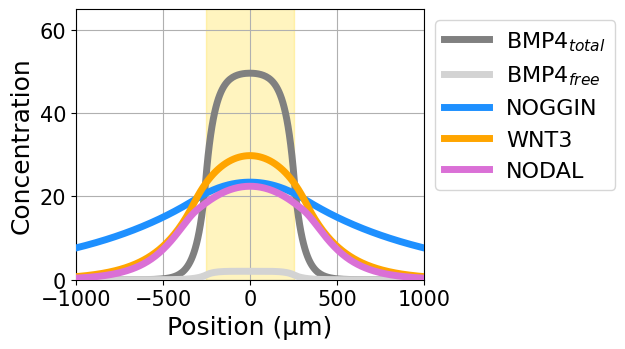

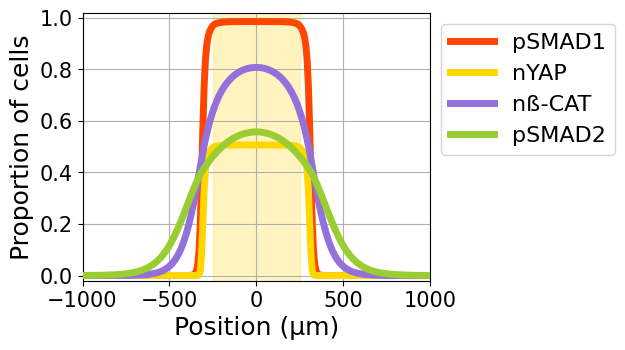

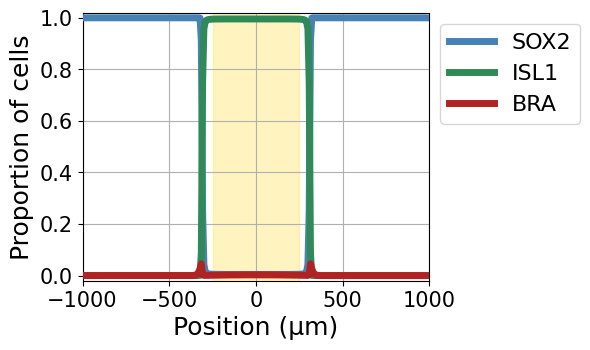

In [10]:
fct.plot_morphogens(x_RCLL, morphogens_RCLL[:,-1], 'RegularCulture_lightBMP4_lowtension', x_light=param["x_light"], micro=False)
fct.plot_TFs(x_RCLL, TFs_RCLL[:,-1], 'RegularCulture_lightBMP4_lowtension', x_light=param["x_light"], micro=False)
fct.plot_fates(x_RCLL, fates_RCLL[:,-1], 'RegularCulture_lightBMP4_lowtension', x_light=param["x_light"], micro=False)

<br>



#### 3. Modeling light-activated BMP4 in regular cultures in the high-tension regime

In [11]:
# Position along the micropattern
param["x_arr_len"] = 1000
param["x_total"] = 3700.
param["x_light"] = 250.
x_RCLH = np.linspace(-param["x_total"], param["x_total"], param["x_arr_len"])

# Parameters
param["times"] = np.linspace(0.1, 5e3, 500)
param["micro"] = False
param["fixed_BMP4"] = 0.
param["T_WNT3"] = 1.2
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

# BMP4, NOGGIN, WNT3 and NODAL concentrations
results_RCLH = fct.integrate(param)
BMP4_RCLH = results_RCLH[:,:param["x_arr_len"]]
NOG_RCLH = results_RCLH[:,param["x_arr_len"]:2*param["x_arr_len"]]
WNT3_RCLH = results_RCLH[:,2*param["x_arr_len"]:3*param["x_arr_len"]]
NODAL_RCLH = results_RCLH[:,3*param["x_arr_len"]:]

# Sensitivity to BMP4 (K parameter)
K_pSMAD1_RCLH = param["K_pSMAD1"]*np.abs(x_RCLH)**25./((param["x_light"]*1.5)**25.+np.abs(x_RCLH)**25.) +0.1

# Free BMP4
free_BMP4_RCLH = BMP4_RCLH/(1.+param["a"]*NOG_RCLH)

# pSMAD1
pSMAD1_RCLH = np.zeros(BMP4_RCLH.shape)
n_pSMAD1 = param["n_pSMAD1"]
pSMAD1_RCLH = free_BMP4_RCLH**n_pSMAD1/(free_BMP4_RCLH**n_pSMAD1+K_pSMAD1_RCLH**n_pSMAD1)

# nYAP
nYAP_RCLH = np.zeros(BMP4_RCLH.shape)
n_nYAP, K_nYAP = param["n_nYAP"], param["K_nYAP"]
nYAP_RCLH = pSMAD1_RCLH**n_nYAP/(pSMAD1_RCLH**n_nYAP+K_nYAP**n_nYAP)

# nß-CATENIN
bCAT_RCLH = np.zeros(BMP4_RCLH.shape)
n_bCAT, K_bCAT = param["n_bCAT"], param["K_bCAT"]
bCAT_RCLH = WNT3_RCLH**n_bCAT/(WNT3_RCLH**n_bCAT+K_bCAT**n_bCAT)

# pSMAD2
pSMAD2_RCLH = np.zeros(BMP4_RCLH.shape)
n_pSMAD2, K_pSMAD2 = param["n_pSMAD2"], param["K_pSMAD2"]
pSMAD2_RCLH = NODAL_RCLH**n_pSMAD2/(NODAL_RCLH**n_pSMAD2+K_pSMAD2**n_pSMAD2)

# ISL1
ISL1_RCLH = np.zeros(BMP4_RCLH.shape)
n_ISL1, K_ISL1 = param["n_ISL1"], param["K_ISL1"]
ISL1_RCLH = pSMAD1_RCLH**n_ISL1/(pSMAD1_RCLH**n_ISL1+K_ISL1**n_ISL1)

# BRA
BRA_RCLH = np.zeros(BMP4_RCLH.shape)
n_BRA, K_BRA, n2_BRA, K2_BRA, n3_BRA, K3_BRA = param["n_BRA"], param["K_BRA"], param["n2_BRA"], param["K2_BRA"], param["n3_BRA"], param["K3_BRA"]
BRA_RCLH = pSMAD2_RCLH**n_BRA/(pSMAD2_RCLH**n_BRA+K_BRA**n_BRA)
BRA_RCLH *= K2_BRA**n2_BRA/(ISL1_RCLH**n2_BRA+K2_BRA**n2_BRA)
BRA_RCLH *= bCAT_RCLH**n3_BRA/(bCAT_RCLH**n3_BRA+K3_BRA**n3_BRA)

# SOX2
SOX2_RCLH = np.ones(BMP4_RCLH.shape)
n_SOX2, K_SOX2, n2_SOX2, K2_SOX2 = param["n_SOX2"], param["K_SOX2"], param["n2_SOX2"], param["K2_SOX2"]
SOX2_RCLH = K_SOX2**n_SOX2/(pSMAD1_RCLH**n_SOX2+K_SOX2**n_SOX2)
SOX2_RCLH *= K2_SOX2**n2_SOX2/(BRA_RCLH**n2_SOX2+K2_SOX2**n2_SOX2)

# Grouping results
morphogens_RCLH = np.array([BMP4_RCLH, free_BMP4_RCLH, NOG_RCLH, WNT3_RCLH, NODAL_RCLH])
TFs_RCLH = np.array([pSMAD1_RCLH, nYAP_RCLH, bCAT_RCLH, pSMAD2_RCLH])
fates_RCLH = np.array([SOX2_RCLH, ISL1_RCLH, BRA_RCLH])

<br>

Figures

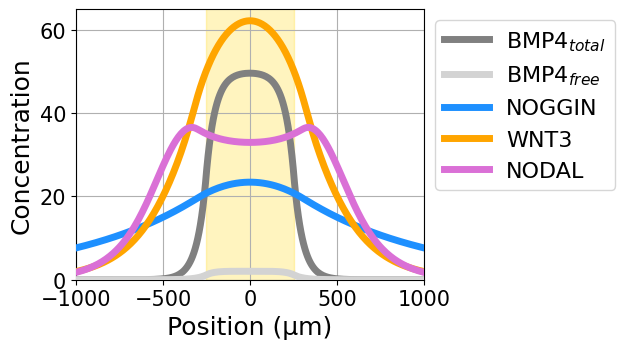

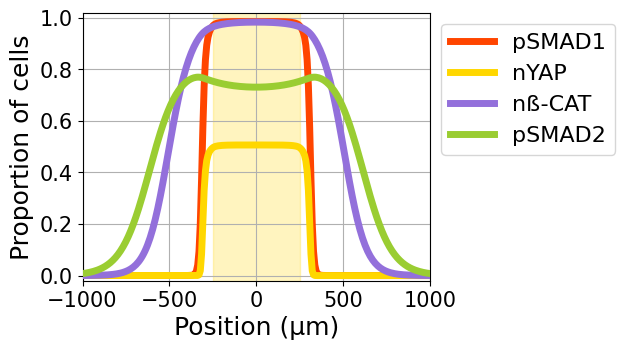

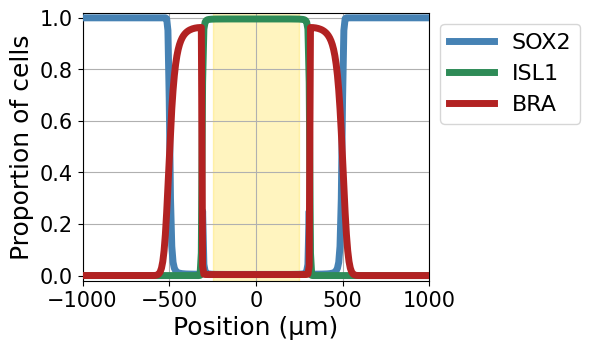

In [12]:
fct.plot_morphogens(x_RCLH, morphogens_RCLH[:,-1], 'RegularCulture_lightBMP4_hightension', x_light=param["x_light"], micro=False)
fct.plot_TFs(x_RCLH, TFs_RCLH[:,-1], 'RegularCulture_lightBMP4_hightension', x_light=param["x_light"], micro=False)
fct.plot_fates(x_RCLH, fates_RCLH[:,-1], 'RegularCulture_lightBMP4_hightension', x_light=param["x_light"], micro=False)

In [9]:
# Position along the micropattern
param["x_arr_len"] = 300
param["x_total"] = 250.
param["x_light"] = 100.
x_MPL = np.linspace(0., param["x_total"], param["x_arr_len"])

# Parameters
param["times"] = np.linspace(0.1, 5e3, 500)
param["micro"] = True
param["fixed_BMP4"] = 0.
param["T_WNT3"] = 0.6
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

# BMP4, NOGGIN, WNT3 and NODAL concentrations
results_MPL = fct.integrate(param)
BMP4_MPL = results_MPL[:,:param["x_arr_len"]]
NOG_MPL = results_MPL[:,param["x_arr_len"]:2*param["x_arr_len"]]
WNT3_MPL = results_MPL[:,2*param["x_arr_len"]:3*param["x_arr_len"]]
NODAL_MPL = results_MPL[:,3*param["x_arr_len"]:]

# Sensitivity to BMP4 (K parameter)
K_pSMAD1 = param["K_pSMAD1"]    
r = x_MPL-param["x_total"]+205.
r[r<0.] = 0.
K1_pSMAD1_MPL = K_pSMAD1/(1.+(r/160.)**35.)+(K_pSMAD1+10.)/110.
K2_pSMAD1_MPL = K_pSMAD1*(x_MPL**25./((param["x_light"]*1.5)**25.+x_MPL**25.))+0.1
K_pSMAD1_MPL = np.min(np.array([K1_pSMAD1_MPL, K2_pSMAD1_MPL]), axis=0)

# Free BMP4
free_BMP4_MPL = BMP4_MPL/(1.+param["a"]*NOG_MPL)

# pSMAD1
pSMAD1_MPL = np.zeros(BMP4_MPL.shape)
n_pSMAD1 = param["n_pSMAD1"]
pSMAD1_MPL = free_BMP4_MPL**n_pSMAD1/(free_BMP4_MPL**n_pSMAD1+K_pSMAD1_MPL**n_pSMAD1)

# nYAP
nYAP_MPL = np.zeros(BMP4_MPL.shape)
n_nYAP, K_nYAP = param["n_nYAP"], param["K_nYAP"]
nYAP_MPL = pSMAD1_MPL**n_nYAP/(pSMAD1_MPL**n_nYAP+K_nYAP**n_nYAP)

# nß-CATENIN
bCAT_MPL = np.zeros(BMP4_MPL.shape)
n_bCAT, K_bCAT = param["n_bCAT"], param["K_bCAT"]
bCAT_MPL = WNT3_MPL**n_bCAT/(WNT3_MPL**n_bCAT+K_bCAT**n_bCAT)

# pSMAD2
pSMAD2_MPL = np.zeros(BMP4_MPL.shape)
n_pSMAD2, K_pSMAD2 = param["n_pSMAD2"], param["K_pSMAD2"]
pSMAD2_MPL = NODAL_MPL**n_pSMAD2/(NODAL_MPL**n_pSMAD2+K_pSMAD2**n_pSMAD2)

# ISL1
ISL1_MPL = np.zeros(BMP4_MPL.shape)
n_ISL1, K_ISL1 = param["n_ISL1"], param["K_ISL1"]
ISL1_MPL = pSMAD1_MPL**n_ISL1/(pSMAD1_MPL**n_ISL1+K_ISL1**n_ISL1)

# BRA
BRA_MPL = np.zeros(BMP4_MPL.shape)
n_BRA, K_BRA, n2_BRA, K2_BRA, n3_BRA, K3_BRA = param["n_BRA"], param["K_BRA"], param["n2_BRA"], param["K2_BRA"], param["n3_BRA"], param["K3_BRA"]
BRA_MPL = pSMAD2_MPL**n_BRA/(pSMAD2_MPL**n_BRA+K_BRA**n_BRA)
BRA_MPL *= K2_BRA**n2_BRA/(ISL1_MPL**n2_BRA+K2_BRA**n2_BRA)
BRA_MPL *= bCAT_MPL**n3_BRA/(bCAT_MPL**n3_BRA+K3_BRA**n3_BRA)

# SOX2
SOX2_MPL = np.ones(BMP4_MPL.shape)
n_SOX2, K_SOX2, n2_SOX2, K2_SOX2 = param["n_SOX2"], param["K_SOX2"], param["n2_SOX2"], param["K2_SOX2"]
SOX2_MPL = K_SOX2**n_SOX2/(pSMAD1_MPL**n_SOX2+K_SOX2**n_SOX2)
SOX2_MPL *= K2_SOX2**n2_SOX2/(BRA_MPL**n2_SOX2+K2_SOX2**n2_SOX2)

# Grouping results
morphogens_MPL = np.array([BMP4_MPL, free_BMP4_MPL, NOG_MPL, WNT3_MPL, NODAL_MPL])
TFs_MPL = np.array([pSMAD1_MPL, nYAP_MPL, bCAT_MPL, pSMAD2_MPL])
fates_MPL = np.array([SOX2_MPL, ISL1_MPL, BRA_MPL])

<br>

Figures

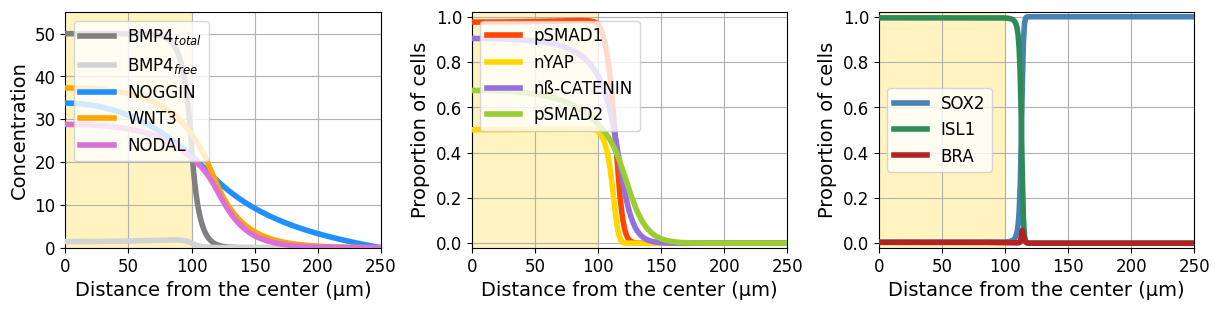

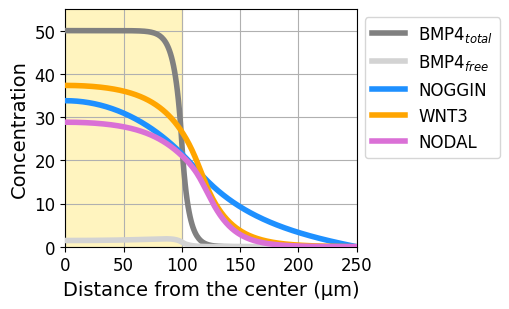

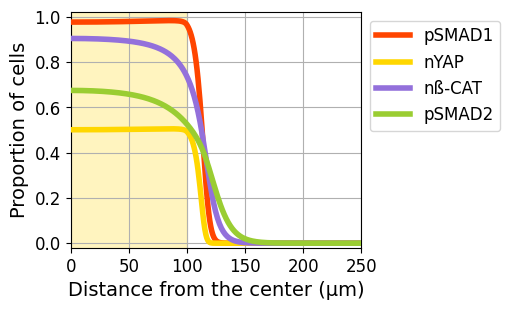

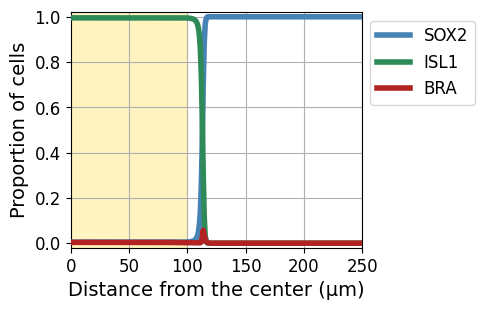

In [20]:
fct.plot_morphogens(x_MPL, morphogens_MPL[:,-1], 'Micropattern_light', x_light=param["x_light"], micro=True)
fct.plot_TFs(x_MPL, TFs_MPL[:,-1], 'Micropattern_light', x_light=param["x_light"], micro=True)
fct.plot_fates(x_MPL, fates_MPL[:,-1], 'Micropattern_light', x_light=param["x_light"], micro=True)

<br>



#### 4. Perturbation 1: no WNT3

In [13]:
# Position along the micropattern
param["x_arr_len"] = 300
param["x_total"] = 250.
x_MPF_P1 = np.linspace(0., param["x_total"], param["x_arr_len"])

# Parameters
param["times"] = np.linspace(0.1, 5e3, 500)
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 0.
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

# BMP4, NOGGIN, WNT3 and NODAL concentrations
results_MPF_P1 = fct.integrate(param)
BMP4_MPF_P1 = results_MPF_P1[:,:param["x_arr_len"]]
NOG_MPF_P1 = results_MPF_P1[:,param["x_arr_len"]:2*param["x_arr_len"]]
WNT3_MPF_P1 = results_MPF_P1[:,2*param["x_arr_len"]:3*param["x_arr_len"]]
NODAL_MPF_P1 = results_MPF_P1[:,3*param["x_arr_len"]:]

# Sensitivity to BMP4 (K parameter)
K_pSMAD1 = param["K_pSMAD1"]    
r = x_MPF_P1-param["x_total"]+205.
r[r<0.] = 0.
K_pSMAD1_MPF_P1 = K_pSMAD1/(1.+(r/160.)**35.)+(K_pSMAD1+10.)/110.

# Free BMP4
free_BMP4_MPF_P1 = BMP4_MPF_P1/(1.+param["a"]*NOG_MPF_P1)

# pSMAD1
pSMAD1_MPF_P1 = np.zeros(BMP4_MPF_P1.shape)
n_pSMAD1 = param["n_pSMAD1"]
pSMAD1_MPF_P1 = free_BMP4_MPF_P1**n_pSMAD1/(free_BMP4_MPF_P1**n_pSMAD1+K_pSMAD1_MPF_P1**n_pSMAD1)

# nYAP
nYAP_MPF_P1 = np.zeros(BMP4_MPF_P1.shape)
n_nYAP, K_nYAP = param["n_nYAP"], param["K_nYAP"]
nYAP_MPF_P1 = pSMAD1_MPF_P1**n_nYAP/(pSMAD1_MPF_P1**n_nYAP+K_nYAP**n_nYAP)

# nß-CATENIN
bCAT_MPF_P1 = np.zeros(BMP4_MPF_P1.shape)
n_bCAT, K_bCAT = param["n_bCAT"], param["K_bCAT"]
bCAT_MPF_P1 = WNT3_MPF_P1**n_bCAT/(WNT3_MPF_P1**n_bCAT+K_bCAT**n_bCAT)

# pSMAD2
pSMAD2_MPF_P1 = np.zeros(BMP4_MPF_P1.shape)
n_pSMAD2, K_pSMAD2 = param["n_pSMAD2"], param["K_pSMAD2"]
pSMAD2_MPF_P1 = NODAL_MPF_P1**n_pSMAD2/(NODAL_MPF_P1**n_pSMAD2+K_pSMAD2**n_pSMAD2)

# ISL1
ISL1_MPF_P1 = np.zeros(BMP4_MPF_P1.shape)
n_ISL1, K_ISL1 = param["n_ISL1"], param["K_ISL1"]
ISL1_MPF_P1 = pSMAD1_MPF_P1**n_ISL1/(pSMAD1_MPF_P1**n_ISL1+K_ISL1**n_ISL1)

# BRA
BRA_MPF_P1 = np.zeros(BMP4_MPF_P1.shape)
n_BRA, K_BRA, n2_BRA, K2_BRA, n3_BRA, K3_BRA = param["n_BRA"], param["K_BRA"], param["n2_BRA"], param["K2_BRA"], param["n3_BRA"], param["K3_BRA"]
BRA_MPF_P1 = pSMAD2_MPF_P1**n_BRA/(pSMAD2_MPF_P1**n_BRA+K_BRA**n_BRA)
BRA_MPF_P1 *= K2_BRA**n2_BRA/(ISL1_MPF_P1**n2_BRA+K2_BRA**n2_BRA)
BRA_MPF_P1 *= bCAT_MPF_P1**n3_BRA/(bCAT_MPF_P1**n3_BRA+K3_BRA**n3_BRA)

# SOX2
SOX2_MPF_P1 = np.ones(BMP4_MPF_P1.shape)
n_SOX2, K_SOX2, n2_SOX2, K2_SOX2 = param["n_SOX2"], param["K_SOX2"], param["n2_SOX2"], param["K2_SOX2"]
SOX2_MPF_P1 = K_SOX2**n_SOX2/(pSMAD1_MPF_P1**n_SOX2+K_SOX2**n_SOX2)
SOX2_MPF_P1 *= K2_SOX2**n2_SOX2/(BRA_MPF_P1**n2_SOX2+K2_SOX2**n2_SOX2)

# Grouping results
morphogens_MPF_P1 = np.array([BMP4_MPF_P1, free_BMP4_MPF_P1, NOG_MPF_P1, WNT3_MPF_P1, NODAL_MPF_P1])
TFs_MPF_P1 = np.array([pSMAD1_MPF_P1, nYAP_MPF_P1, bCAT_MPF_P1, pSMAD2_MPF_P1])
fates_MPF_P1 = np.array([SOX2_MPF_P1, ISL1_MPF_P1, BRA_MPF_P1])

<br>

Figures

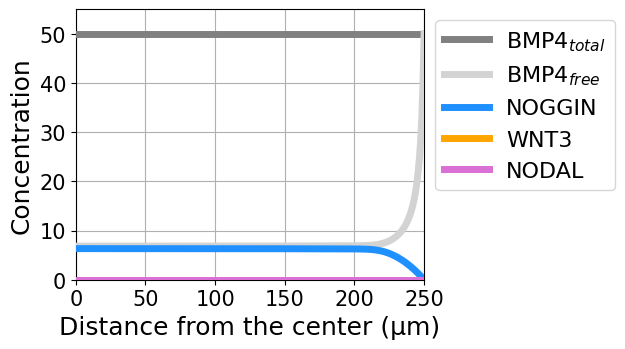

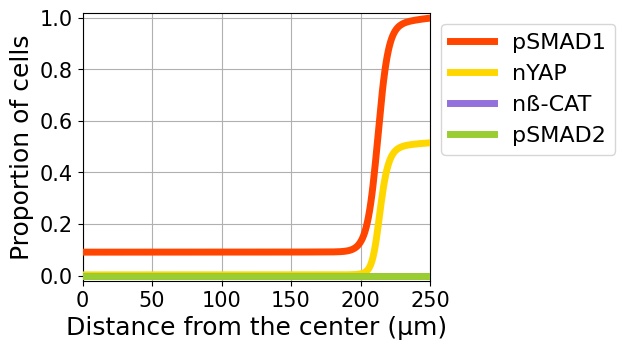

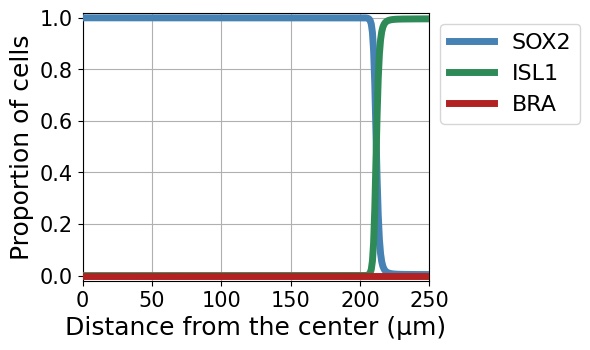

In [14]:
fct.plot_morphogens(x_MPF_P1, morphogens_MPF_P1[:,-1], 'Micropattern_noWNT3', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF_P1, TFs_MPF_P1[:,-1], 'Micropattern_noWNT3', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF_P1, fates_MPF_P1[:,-1], 'Micropattern_noWNT3', micro=True, fixed_BMP4=True)

<br>



#### 5. Perturbation 2: more nYAP

In [15]:
# Position along the micropattern
param["x_arr_len"] = 300
param["x_total"] = 250.
x_MPF_P2 = np.linspace(0., param["x_total"], param["x_arr_len"])

# Parameters
param["times"] = np.linspace(0.1, 5e3, 500)
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 0.6
param["fixed_nYAP"] = 0.4
param["p_NOG"] = 0.07

# BMP4, NOGGIN, WNT3 and NODAL concentrations
results_MPF_P2 = fct.integrate(param)
BMP4_MPF_P2 = results_MPF_P2[:,:param["x_arr_len"]]
NOG_MPF_P2 = results_MPF_P2[:,param["x_arr_len"]:2*param["x_arr_len"]]
WNT3_MPF_P2 = results_MPF_P2[:,2*param["x_arr_len"]:3*param["x_arr_len"]]
NODAL_MPF_P2 = results_MPF_P2[:,3*param["x_arr_len"]:]

# Sensitivity to BMP4 (K parameter)
K_pSMAD1 = param["K_pSMAD1"]    
r = x_MPF_P2-param["x_total"]+205.
r[r<0.] = 0.
K_pSMAD1_MPF_P2 = K_pSMAD1/(1.+(r/160.)**35.)+(K_pSMAD1+10.)/110.

# Free BMP4
free_BMP4_MPF_P2 = BMP4_MPF_P2/(1.+param["a"]*NOG_MPF_P2)

# pSMAD1
pSMAD1_MPF_P2 = np.zeros(BMP4_MPF_P2.shape)
n_pSMAD1 = param["n_pSMAD1"]
pSMAD1_MPF_P2 = free_BMP4_MPF_P2**n_pSMAD1/(free_BMP4_MPF_P2**n_pSMAD1+K_pSMAD1_MPF_P2**n_pSMAD1)

# nYAP
nYAP_MPF_P2 = np.zeros(BMP4_MPF_P2.shape)+param["fixed_nYAP"]

# nß-CATENIN
bCAT_MPF_P2 = np.zeros(BMP4_MPF_P2.shape)
n_bCAT, K_bCAT = param["n_bCAT"], param["K_bCAT"]
bCAT_MPF_P2 = WNT3_MPF_P2**n_bCAT/(WNT3_MPF_P2**n_bCAT+K_bCAT**n_bCAT)

# pSMAD2
pSMAD2_MPF_P2 = np.zeros(BMP4_MPF_P2.shape)
n_pSMAD2, K_pSMAD2 = param["n_pSMAD2"], param["K_pSMAD2"]
pSMAD2_MPF_P2 = NODAL_MPF_P2**n_pSMAD2/(NODAL_MPF_P2**n_pSMAD2+K_pSMAD2**n_pSMAD2)

# ISL1
ISL1_MPF_P2 = np.zeros(BMP4_MPF_P2.shape)
n_ISL1, K_ISL1 = param["n_ISL1"], param["K_ISL1"]
ISL1_MPF_P2 = pSMAD1_MPF_P2**n_ISL1/(pSMAD1_MPF_P2**n_ISL1+K_ISL1**n_ISL1)

# BRA
BRA_MPF_P2 = np.zeros(BMP4_MPF_P2.shape)
n_BRA, K_BRA, n2_BRA, K2_BRA, n3_BRA, K3_BRA = param["n_BRA"], param["K_BRA"], param["n2_BRA"], param["K2_BRA"], param["n3_BRA"], param["K3_BRA"]
BRA_MPF_P2 = pSMAD2_MPF_P2**n_BRA/(pSMAD2_MPF_P2**n_BRA+K_BRA**n_BRA)
BRA_MPF_P2 *= K2_BRA**n2_BRA/(ISL1_MPF_P2**n2_BRA+K2_BRA**n2_BRA)
BRA_MPF_P2 *= bCAT_MPF_P2**n3_BRA/(bCAT_MPF_P2**n3_BRA+K3_BRA**n3_BRA)

# SOX2
SOX2_MPF_P2 = np.ones(BMP4_MPF_P2.shape)
n_SOX2, K_SOX2, n2_SOX2, K2_SOX2 = param["n_SOX2"], param["K_SOX2"], param["n2_SOX2"], param["K2_SOX2"]
SOX2_MPF_P2 = K_SOX2**n_SOX2/(pSMAD1_MPF_P2**n_SOX2+K_SOX2**n_SOX2)
SOX2_MPF_P2 *= K2_SOX2**n2_SOX2/(BRA_MPF_P2**n2_SOX2+K2_SOX2**n2_SOX2)

# Grouping results
morphogens_MPF_P2 = np.array([BMP4_MPF_P2, free_BMP4_MPF_P2, NOG_MPF_P2, WNT3_MPF_P2, NODAL_MPF_P2])
TFs_MPF_P2 = np.array([pSMAD1_MPF_P2, nYAP_MPF_P2, bCAT_MPF_P2, pSMAD2_MPF_P2])
fates_MPF_P2 = np.array([SOX2_MPF_P2, ISL1_MPF_P2, BRA_MPF_P2])

<br>

Figures

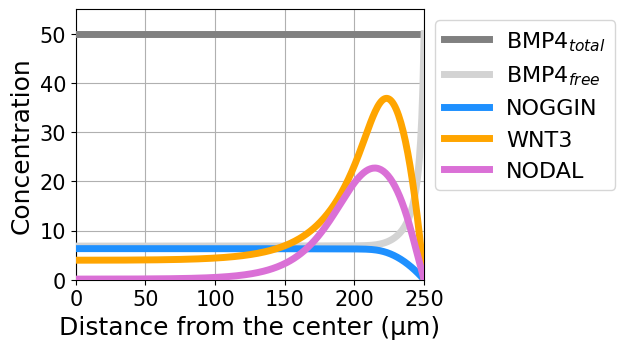

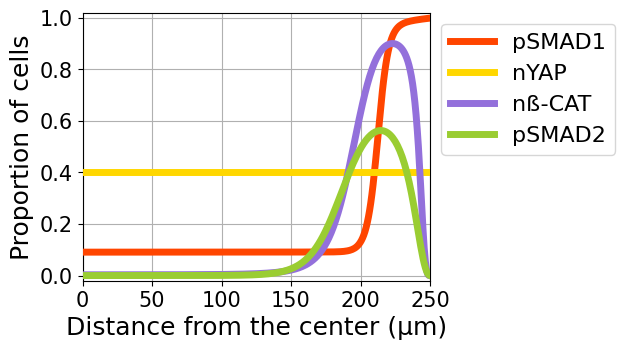

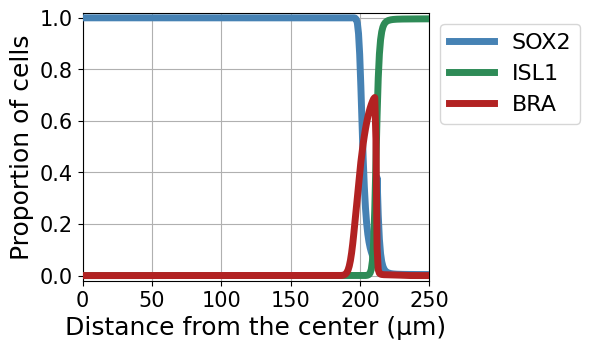

In [16]:
fct.plot_morphogens(x_MPF_P2, morphogens_MPF_P2[:,-1], 'Micropattern_moreYAP', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF_P2, TFs_MPF_P2[:,-1], 'Micropattern_moreYAP', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF_P2, fates_MPF_P2[:,-1], 'Micropattern_moreYAP', micro=True, fixed_BMP4=True)

<br>



#### 6. Perturbation 3: no NOGGIN

In [17]:
# Position along the micropattern
param["x_arr_len"] = 300
param["x_total"] = 250.
x_MPF_P3 = np.linspace(0., param["x_total"], param["x_arr_len"])

# Parameters
param["times"] = np.linspace(0.1, 5e3, 500)
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 0.6
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.

# BMP4, NOGGIN, WNT3 and NODAL concentrations
results_MPF_P3 = fct.integrate(param)
BMP4_MPF_P3 = results_MPF_P3[:,:param["x_arr_len"]]
NOG_MPF_P3 = results_MPF_P3[:,param["x_arr_len"]:2*param["x_arr_len"]]
WNT3_MPF_P3 = results_MPF_P3[:,2*param["x_arr_len"]:3*param["x_arr_len"]]
NODAL_MPF_P3 = results_MPF_P3[:,3*param["x_arr_len"]:]

# Sensitivity to BMP4 (K parameter)
K_pSMAD1 = param["K_pSMAD1"]    
r = x_MPF_P3-param["x_total"]+205.
r[r<0.] = 0.
K_pSMAD1_MPF_P3 = K_pSMAD1/(1.+(r/160.)**35.)+(K_pSMAD1+10.)/110.

# Free BMP4
free_BMP4_MPF_P3 = BMP4_MPF_P3/(1.+param["a"]*NOG_MPF_P3)

# pSMAD1
pSMAD1_MPF_P3 = np.zeros(BMP4_MPF_P3.shape)
n_pSMAD1 = param["n_pSMAD1"]
pSMAD1_MPF_P3 = free_BMP4_MPF_P3**n_pSMAD1/(free_BMP4_MPF_P3**n_pSMAD1+K_pSMAD1_MPF_P3**n_pSMAD1)

# nYAP
nYAP_MPF_P3 = np.zeros(BMP4_MPF_P3.shape)
n_nYAP, K_nYAP = param["n_nYAP"], param["K_nYAP"]
nYAP_MPF_P3 = pSMAD1_MPF_P3**n_nYAP/(pSMAD1_MPF_P3**n_nYAP+K_nYAP**n_nYAP)

# nß-CATENIN
bCAT_MPF_P3 = np.zeros(BMP4_MPF_P3.shape)
n_bCAT, K_bCAT = param["n_bCAT"], param["K_bCAT"]
bCAT_MPF_P3 = WNT3_MPF_P3**n_bCAT/(WNT3_MPF_P3**n_bCAT+K_bCAT**n_bCAT)

# pSMAD2
pSMAD2_MPF_P3 = np.zeros(BMP4_MPF_P3.shape)
n_pSMAD2, K_pSMAD2 = param["n_pSMAD2"], param["K_pSMAD2"]
pSMAD2_MPF_P3 = NODAL_MPF_P3**n_pSMAD2/(NODAL_MPF_P3**n_pSMAD2+K_pSMAD2**n_pSMAD2)

# ISL1
ISL1_MPF_P3 = np.zeros(BMP4_MPF_P3.shape)
n_ISL1, K_ISL1 = param["n_ISL1"], param["K_ISL1"]
ISL1_MPF_P3 = pSMAD1_MPF_P3**n_ISL1/(pSMAD1_MPF_P3**n_ISL1+K_ISL1**n_ISL1)

# BRA
BRA_MPF_P3 = np.zeros(BMP4_MPF_P3.shape)
n_BRA, K_BRA, n2_BRA, K2_BRA, n3_BRA, K3_BRA = param["n_BRA"], param["K_BRA"], param["n2_BRA"], param["K2_BRA"], param["n3_BRA"], param["K3_BRA"]
BRA_MPF_P3 = pSMAD2_MPF_P3**n_BRA/(pSMAD2_MPF_P3**n_BRA+K_BRA**n_BRA)
BRA_MPF_P3 *= K2_BRA**n2_BRA/(ISL1_MPF_P3**n2_BRA+K2_BRA**n2_BRA)
BRA_MPF_P3 *= bCAT_MPF_P3**n3_BRA/(bCAT_MPF_P3**n3_BRA+K3_BRA**n3_BRA)

# SOX2
SOX2_MPF_P3 = np.ones(BMP4_MPF_P3.shape)
n_SOX2, K_SOX2, n2_SOX2, K2_SOX2 = param["n_SOX2"], param["K_SOX2"], param["n2_SOX2"], param["K2_SOX2"]
SOX2_MPF_P3 = K_SOX2**n_SOX2/(pSMAD1_MPF_P3**n_SOX2+K_SOX2**n_SOX2)
SOX2_MPF_P3 *= K2_SOX2**n2_SOX2/(BRA_MPF_P3**n2_SOX2+K2_SOX2**n2_SOX2)

# Grouping results
morphogens_MPF_P3 = np.array([BMP4_MPF_P3, free_BMP4_MPF_P3, NOG_MPF_P3, WNT3_MPF_P3, NODAL_MPF_P3])
TFs_MPF_P3 = np.array([pSMAD1_MPF_P3, nYAP_MPF_P3, bCAT_MPF_P3, pSMAD2_MPF_P3])
fates_MPF_P3 = np.array([SOX2_MPF_P3, ISL1_MPF_P3, BRA_MPF_P3])

<br>

Figures

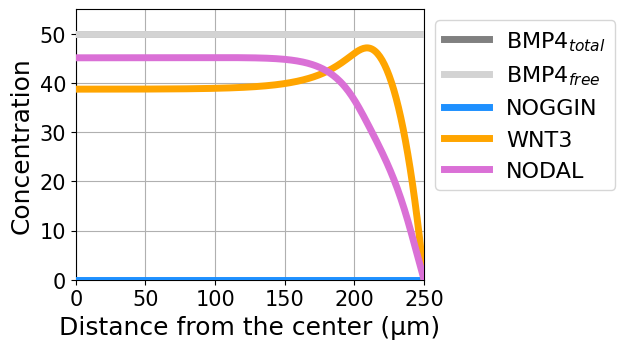

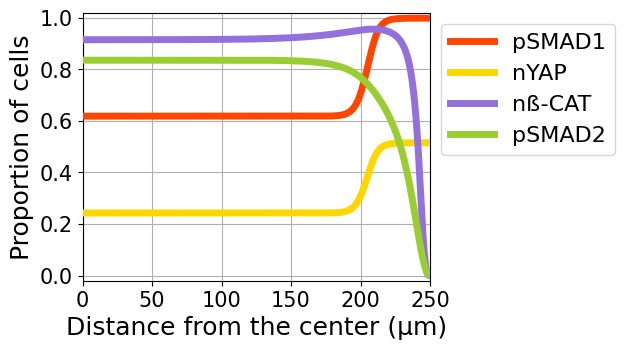

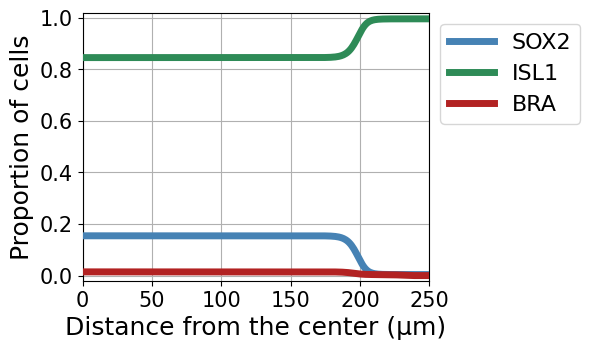

In [18]:
fct.plot_morphogens(x_MPF_P3, morphogens_MPF_P3[:,-1], 'Micropattern_noNOGGIN', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF_P3, TFs_MPF_P3[:,-1], 'Micropattern_noNOGGIN', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF_P3, fates_MPF_P3[:,-1], 'Micropattern_noNOGGIN', micro=True, fixed_BMP4=True)